In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [3]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-05-11 06:06:04,922 INFO: Initializing external client
2025-05-11 06:06:04,922 INFO: Base URL: https://c.app.hopsworks.ai:443




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'


2025-05-11 06:06:05,615 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214695


In [4]:
feature_group.schema

[Feature('pickup_hour', 'timestamp', None, True, False, None, None, 1458598),
 Feature('pickup_location_id', 'int', None, True, False, None, None, 1458598),
 Feature('rides', 'int', None, False, False, None, None, 1458598)]

In [5]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1214695/fs/1202330/fv/citi_bike_ds/version/1
Feature view 'citi_bike_ds' (version 1) created successfully.
Feature view 'citi_bike_ds' (version 1) retrieved successfully.


In [6]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly citi bike rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.52s) 


In [7]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [8]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2023-12-31 20:00:00+00:00,5626,4
1,2024-01-01 00:00:00+00:00,5626,42
2,2024-01-01 04:00:00+00:00,5626,9
3,2024-01-01 08:00:00+00:00,5626,40
4,2024-01-01 12:00:00+00:00,5626,76


In [9]:
ts_data["pickup_hour"].min()

'2023-12-31 20:00:00+00:00'

In [10]:
ts_data["pickup_hour"].max()

'2025-05-11 04:00:00+00:00'

In [11]:
ts_data_copy = ts_data.copy()

In [12]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [13]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11855 entries, 0 to 11854
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   pickup_hour         11855 non-null  datetime64[ns, UTC]
 1   pickup_location_id  11855 non-null  int32              
 2   rides               11855 non-null  int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 185.4 KB


In [14]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [15]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11855 entries, 0 to 11854
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pickup_hour         11855 non-null  datetime64[ns]
 1   pickup_location_id  11855 non-null  int32         
 2   rides               11855 non-null  int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 185.4 KB


In [16]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [17]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2023-12-31 20:00:00,5626,4,2023-12
1,2024-01-01 00:00:00,5626,42,2024-01
2,2024-01-01 04:00:00,5626,9,2024-01
3,2024-01-01 08:00:00,5626,40,2024-01
4,2024-01-01 12:00:00,5626,76,2024-01
...,...,...,...,...
11850,2025-05-10 12:00:00,6072,85,2025-05
11851,2025-05-10 16:00:00,6072,59,2025-05
11852,2025-05-10 20:00:00,6072,54,2025-05
11853,2025-05-11 00:00:00,6072,23,2025-05


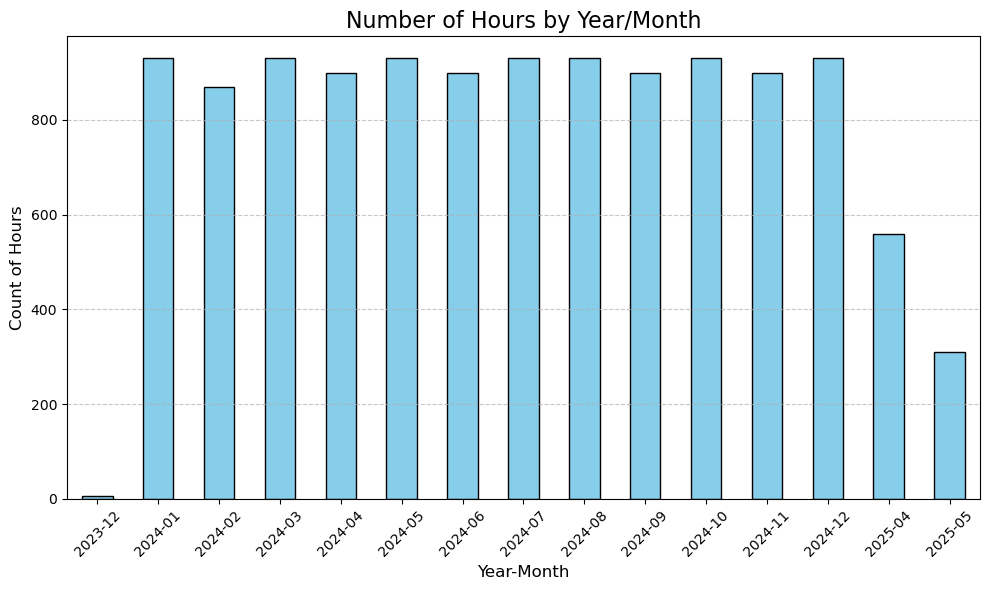

In [18]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [19]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2023-12-31 20:00:00,5626,4,2023-12
1,2024-01-01 00:00:00,5626,42,2024-01
2,2024-01-01 04:00:00,5626,9,2024-01
3,2024-01-01 08:00:00,5626,40,2024-01
4,2024-01-01 12:00:00,5626,76,2024-01


In [20]:
gte = ts_data["year_month"] >= pd.Period("2024-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2024-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [21]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [22]:
filtered_data.shape

(10980, 3)

In [23]:
ts_data = filtered_data

In [24]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10980 entries, 0 to 10979
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pickup_hour         10980 non-null  datetime64[ns]
 1   pickup_location_id  10980 non-null  int32         
 2   rides               10980 non-null  int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 171.7 KB


In [25]:
ts_data.head()["pickup_hour"].values

array(['2024-01-01T00:00:00.000000000', '2024-01-01T04:00:00.000000000',
       '2024-01-01T08:00:00.000000000', '2024-01-01T12:00:00.000000000',
       '2024-01-01T16:00:00.000000000'], dtype='datetime64[ns]')

In [26]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=6*28, step_size=1)

In [27]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-168,rides_t-167,rides_t-166,rides_t-165,rides_t-164,rides_t-163,rides_t-162,rides_t-161,rides_t-160,rides_t-159,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,42,9,40,76,65,30,4,40,73,68,...,106,60,25,3,28,37,49,40,2024-01-29 00:00:00,5626
1,9,40,76,65,30,4,40,73,68,87,...,60,25,3,28,37,49,40,10,2024-01-29 04:00:00,5626
2,40,76,65,30,4,40,73,68,87,43,...,25,3,28,37,49,40,10,25,2024-01-29 08:00:00,5626
3,76,65,30,4,40,73,68,87,43,9,...,3,28,37,49,40,10,25,89,2024-01-29 12:00:00,5626
4,65,30,4,40,73,68,87,43,9,34,...,28,37,49,40,10,25,89,83,2024-01-29 16:00:00,5626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10135,32,137,111,133,51,9,31,137,108,147,...,42,8,13,52,118,88,45,14,2024-12-31 04:00:00,6072
10136,137,111,133,51,9,31,137,108,147,48,...,8,13,52,118,88,45,14,8,2024-12-31 08:00:00,6072
10137,111,133,51,9,31,137,108,147,48,5,...,13,52,118,88,45,14,8,80,2024-12-31 12:00:00,6072
10138,133,51,9,31,137,108,147,48,5,27,...,52,118,88,45,14,8,80,105,2024-12-31 16:00:00,6072


In [28]:
features[features["pickup_location_id"] == 5626]

,rides_t-168,rides_t-167,rides_t-166,rides_t-165,rides_t-164,rides_t-163,rides_t-162,rides_t-161,rides_t-160,rides_t-159,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,42,9,40,76,65,30,4,40,73,68,...,106,60,25,3,28,37,49,40,2024-01-29 00:00:00,5626
1,9,40,76,65,30,4,40,73,68,87,...,60,25,3,28,37,49,40,10,2024-01-29 04:00:00,5626
2,40,76,65,30,4,40,73,68,87,43,...,25,3,28,37,49,40,10,25,2024-01-29 08:00:00,5626
3,76,65,30,4,40,73,68,87,43,9,...,3,28,37,49,40,10,25,89,2024-01-29 12:00:00,5626
4,65,30,4,40,73,68,87,43,9,34,...,28,37,49,40,10,25,89,83,2024-01-29 16:00:00,5626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,69,146,127,178,92,13,66,177,125,158,...,55,13,21,96,157,120,82,35,2024-12-31 04:00:00,5626
2024,146,127,178,92,13,66,177,125,158,70,...,13,21,96,157,120,82,35,22,2024-12-31 08:00:00,5626
2025,127,178,92,13,66,177,125,158,70,8,...,21,96,157,120,82,35,22,78,2024-12-31 12:00:00,5626
2026,178,92,13,66,177,125,158,70,8,55,...,96,157,120,82,35,22,78,145,2024-12-31 16:00:00,5626


In [29]:
features_copy = features.copy()

In [30]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(10140, 171)

In [53]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = datetime(2024, 10, 1, 0, 0, 0)  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

datetime.datetime(2024, 10, 1, 0, 0)

In [54]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7380, 170)
(7380,)
(2760, 170)
(2760,)


In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10140 entries, 0 to 10139
Columns: 170 entries, rides_t-168 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(168)
memory usage: 13.1 MB


In [34]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [35]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43108
[LightGBM] [Info] Number of data points in the train set: 10140, number of used features: 171
[LightGBM] [Info] Start training from score 128.045858


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x3283ab370>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [36]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [37]:
predictions

array([ 10.03804895,  27.85759667,  77.04022079, ..., 113.27859286,
        83.21700415,  17.42049613])

In [38]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

12.7807


In [39]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['/Users/narendravarma/Documents/citi_bike_system/models/lgb_model.pkl']

In [40]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [44]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="bike_demand_predictor_next_4hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')

In [45]:
model.save('/Users/narendravarma/Documents/citi_bike_system/models')

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/287926 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/805 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/12417 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1214695/models/bike_demand_predictor_next_4hour/1


Model(name: 'bike_demand_predictor_next_4hour', version: 1)

In [48]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-05-11 07:03:08,746 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-11 07:03:08,748 INFO: Initializing external client
2025-05-11 07:03:08,748 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-05-11 07:03:09,272 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214695


In [49]:
from src.inference import get_model_predictions

In [50]:
preds = get_model_predictions(model, features_copy)

In [51]:
preds

,pickup_location_id,predicted_demand
0,5626,10.0
1,5626,28.0
2,5626,77.0
3,5626,80.0
4,5626,90.0
...,...,...
10135,6072,22.0
10136,6072,67.0
10137,6072,113.0
10138,6072,83.0


In [52]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

12.7773
